In [ ]:
!pip install autogluon.timeseries[all] seaborn[stats]

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from pandas import DataFrame
import numpy as np
import pandas as pd
from datetime import timedelta
import calendar


In [ ]:
df = pd.read_csv("drive/MyDrive/Colab Data/AutoGluon/PJM_Load_hourly.csv")
df.head(10)

,Datetime,PJM_Load_MW
0,4/1/1998 1:00,22259
1,4/1/1998 2:00,21244
2,4/1/1998 3:00,20651
3,4/1/1998 4:00,20421
4,4/1/1998 5:00,20713
5,4/1/1998 6:00,22526
6,4/1/1998 7:00,25772
7,4/1/1998 8:00,28724
8,4/1/1998 9:00,30075
9,4/1/1998 10:00,30689


In [ ]:
df['timestamp'] = pd.to_datetime(df['Datetime'])
df['target'] = df['PJM_Load_MW']

df = df[['timestamp', 'target']]
df.head(10)


,timestamp,target
0,1998-04-01 01:00:00,22259
1,1998-04-01 02:00:00,21244
2,1998-04-01 03:00:00,20651
3,1998-04-01 04:00:00,20421
4,1998-04-01 05:00:00,20713
5,1998-04-01 06:00:00,22526
6,1998-04-01 07:00:00,25772
7,1998-04-01 08:00:00,28724
8,1998-04-01 09:00:00,30075
9,1998-04-01 10:00:00,30689


In [ ]:
#add seasonality
final_data = df
final_data['date'] = pd.to_datetime(final_data['timestamp'], format='%Y-%m-%d')
final_data['hour'] = final_data['timestamp'].dt.hour
final_data['day_of_week'] = final_data['timestamp'].dt.dayofweek
final_data['month'] = final_data['timestamp'].dt.month
final_data.head(10)

<ipython-input-36-66520a8ddbda>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['date'] = pd.to_datetime(final_data['timestamp'], format='%Y-%m-%d')


,timestamp,target,date,hour,day_of_week,month
0,1998-04-01 01:00:00,22259,1998-04-01 01:00:00,1,2,4
1,1998-04-01 02:00:00,21244,1998-04-01 02:00:00,2,2,4
2,1998-04-01 03:00:00,20651,1998-04-01 03:00:00,3,2,4
3,1998-04-01 04:00:00,20421,1998-04-01 04:00:00,4,2,4
4,1998-04-01 05:00:00,20713,1998-04-01 05:00:00,5,2,4
5,1998-04-01 06:00:00,22526,1998-04-01 06:00:00,6,2,4
6,1998-04-01 07:00:00,25772,1998-04-01 07:00:00,7,2,4
7,1998-04-01 08:00:00,28724,1998-04-01 08:00:00,8,2,4
8,1998-04-01 09:00:00,30075,1998-04-01 09:00:00,9,2,4
9,1998-04-01 10:00:00,30689,1998-04-01 10:00:00,10,2,4


In [ ]:
#prep for training

#remove extra columns
finaldf = final_data.drop(['date','timestamp'], axis=1)
finaldf = finaldf.reset_index(drop=True)

test_length=8760 #365 days

end_point = len(finaldf)
x = end_point - test_length

#set training data params
finaldf_train = finaldf.loc[:x - 1, :]
finaldf_test = finaldf.loc[x:, :]
finaldf_test_x = finaldf_test.loc[:, finaldf_test.columns != 'target']
finaldf_test_y = finaldf_test['target']
finaldf_train_x = finaldf_train.loc[:, finaldf_train.columns != 'target']
finaldf_train_y = finaldf_train['target']


In [ ]:
%%time
print("Starting Training..")

#original = estimator = RandomForestRegressor(n_jobs=-1, max_depth=5, n_estimators=100, random_state=42, oob_score=True)

#tuned parameters
estimator = RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=5,min_samples_split=12, n_estimators=200)

rfe = RFE(estimator, n_features_to_select=4)
fit = rfe.fit(finaldf_train_x, finaldf_train_y)
y_pred = fit.predict(finaldf_test_x)

Starting Training..
CPU times: user 2.86 s, sys: 27 ms, total: 2.89 s
Wall time: 2.95 s


In [ ]:
#eval
y_true = np.array(finaldf_test_y)
sumvalue=np.sum(y_true)
mape=np.sum(np.abs((y_true - y_pred)))/sumvalue*100
accuracy=100-mape
print('Accuracy:', round(accuracy,2),'%.')

Accuracy: 93.41 %.


In [ ]:
# Step 3: Prediction
future = pd.date_range(start='2001-12-30', end='2002-01-01', freq='H').to_series()
future_df = pd.DataFrame({'timestamp': future})
future_df['hour'] = future_df['timestamp'].dt.hour
future_df['day_of_week'] = future_df['timestamp'].dt.dayofweek
future_df['month'] = future_df['timestamp'].dt.month

future_df = future_df.drop(['timestamp'], axis=1)
future_df.head(10)



,hour,day_of_week,month
2001-12-30 00:00:00,0,6,12
2001-12-30 01:00:00,1,6,12
2001-12-30 02:00:00,2,6,12
2001-12-30 03:00:00,3,6,12
2001-12-30 04:00:00,4,6,12
2001-12-30 05:00:00,5,6,12
2001-12-30 06:00:00,6,6,12
2001-12-30 07:00:00,7,6,12
2001-12-30 08:00:00,8,6,12
2001-12-30 09:00:00,9,6,12


In [ ]:
# Make predictions
future_predictions = fit.predict(future_df)
print(future_predictions)

[27543.47448226 25535.92165907 24372.45796444 23751.2918577
 23419.39877794 23450.08959982 24034.11922114 24955.81143038
 26063.92689191 27442.54746103 28428.79621351 28500.83539676
 28410.289796   28115.1445037  27689.41009738 27357.04886631
 27435.45952109 29094.6936552  32218.02944112 32595.52102032
 32516.88345542 32079.5670906  31123.30619703 29469.09377599
 27149.09314321 24984.35090664 24014.55610762 23862.23847347
 24025.45065069 24463.27179511 26104.59173002 29626.49697129
 32089.1936717  32821.36798082 33101.21262068 33142.24377089
 32891.92335218 32377.93173946 32181.4307199  31668.11278946
 31652.76147418 33128.6938315  35888.14976799 36207.60537037
 35551.30494177 34925.37753972 33588.34678073 31187.53952844
 29318.66655948]


In [ ]:
future_df['predicted'] = future_predictions
future_df.head(10)

,hour,day_of_week,month,predicted
2001-12-30 00:00:00,0,6,12,27543.474482
2001-12-30 01:00:00,1,6,12,25535.921659
2001-12-30 02:00:00,2,6,12,24372.457964
2001-12-30 03:00:00,3,6,12,23751.291858
2001-12-30 04:00:00,4,6,12,23419.398778
2001-12-30 05:00:00,5,6,12,23450.089600
2001-12-30 06:00:00,6,6,12,24034.119221
2001-12-30 07:00:00,7,6,12,24955.811430
2001-12-30 08:00:00,8,6,12,26063.926892
2001-12-30 09:00:00,9,6,12,27442.547461


In [ ]:
from autogluon.timeseries import TimeSeriesDataFrame
if not 'item_id' in df:
  df.insert(0, "item_id", "H1")

plot_data = TimeSeriesDataFrame.from_data_frame(final_data)
plot_data.head()

target                date  hour  day_of_week  \
item_id timestamp                                                            
H1      1998-04-01 01:00:00   22259 1998-04-01 01:00:00     1            2   
        1998-04-01 02:00:00   21244 1998-04-01 02:00:00     2            2   
        1998-04-01 03:00:00   20651 1998-04-01 03:00:00     3            2   
        1998-04-01 04:00:00   20421 1998-04-01 04:00:00     4            2   
        1998-04-01 05:00:00   20713 1998-04-01 05:00:00     5            2   

                             month  
item_id timestamp                   
H1      1998-04-01 01:00:00      4  
        1998-04-01 02:00:00      4  
        1998-04-01 03:00:00      4  
        1998-04-01 04:00:00      4  
        1998-04-01 05:00:00      4

In [ ]:
fix_plot_data = plot_data.to_regular_index(freq='H')
print(f"Data has frequency '{fix_plot_data.freq}'")

Data has frequency 'H'


In [ ]:
print(f"Does it have any missing data? '{fix_plot_data.isnull().values.any()}'")

Does it have any missing data? 'True'


In [ ]:
if fix_plot_data.isnull().values.any():
  fix_plot_data = fix_plot_data.fill_missing_values()

print(f"Does it have any missing data? '{fix_plot_data.isnull().values.any()}'")

Does it have any missing data? 'False'


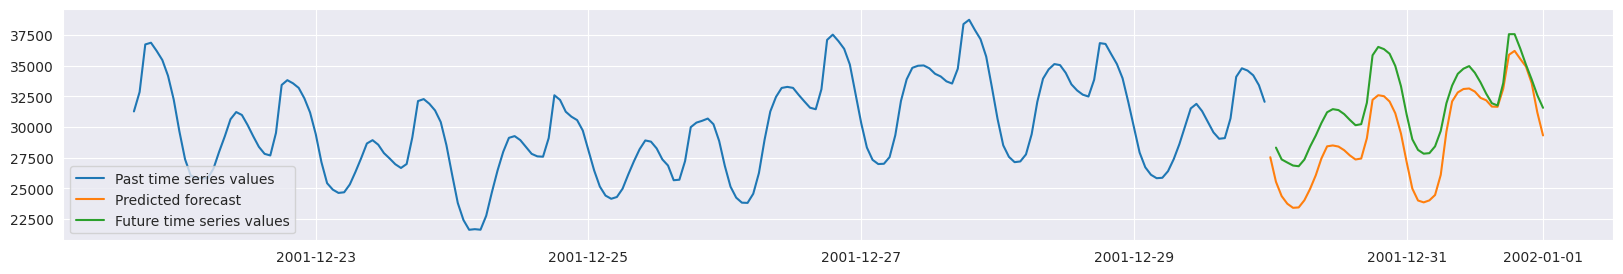

In [ ]:
import seaborn as sb
import matplotlib.pyplot as plt
from autogluon.timeseries import TimeSeriesDataFrame

sb.set_style("darkgrid")
# TimeSeriesDataFrame can also be loaded directly from a file
test_data = TimeSeriesDataFrame.from_path("drive/MyDrive/Colab Data/AutoGluon/test_energy.csv")



plt.figure(figsize=(20, 3))

item_id = "H1"
y_past = fix_plot_data.loc[item_id]["target"]
y_pred = future_df["predicted"]
y_test = test_data.loc["H1"]["target"][-48:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred, label="Predicted forecast")
plt.plot(y_test, label="Future time series values")

# plt.fill_between(
#     y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
# )
plt.legend();

In [ ]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search

# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }
# # Create a based model
# rf = RandomForestRegressor()

# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
#                           cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# %%time
# #tune parameters
# grid_search.fit(finaldf_train_x, finaldf_train_y)
# grid_search.best_params_

In [ ]:
# grid_search.best_score_

In [ ]:
# grid_search.best_estimator_

##Result was: RandomForestRegressor(max_depth=90, max_features=2, min_samples_leaf=5,min_samples_split=12, n_estimators=200)